In [1]:
from queue import Queue
from numpy import mean
from numpy import std
from numpy import dstack
from numpy import array, dstack
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import SpatialDropout1D
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.utils import to_categorical
from keras.models import load_model
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, LayerNormalization, Dense, Attention, MultiHeadAttention, Lambda
from tensorflow.keras.models import Model
# import pygame
import sys
import os
#pygame.init()
# engine = pyttsx3.init() # object creation
SERIAL_PORT = '/dev/cu.DATN'
# be sure to set this to the same rate used on the Arduino
SERIAL_RATE = 38400
test_counter = 240
queue_size = 240
verbose, epochs, batch_size = 1, 40, 300
dataset_path = "./datatrain_40/total/"
trainx_file = "./datatrain_40/total/trainx.txt"
trainy_file = "./datatrain_40/total/trainy.txt"
testx_file = "./datatrain_40/total/testx.txt"
testy_file = "./datatrain_40/total/testy.txt"
config_file = "./datatrain_40/total/config.txt"
enlarged_dataset_path = "./datatrain_40/total/augmentation/"


# screen_width = 800
# screen_height = 600
# screen = pygame.display.set_mode((screen_width, screen_height))
# pygame.display.set_caption("Real-time Display")

# Set up fonts
#font = pygame.font.Font(None, 36)
#WHITE = (255, 255, 255)
""" RATE"""
#rate = engine.getProperty('rate')   # getting details of current speaking rate
# engine.setProperty('rate', 125)     # setting up new voice rate
"""VOLUME"""
#volume = engine.getProperty('volume')   #getting to know current volume level (min=0 and max=1)
#print (volume)                          #printing current volume level
# engine.setProperty('volume',1.0)    # setting up volume level  between 0 and 1

"""VOICE"""
#voices = engine.getProperty('voices')       #getting details of current voice
#engine.setProperty('voice', voices[0].id)  #changing index, changes voices. o for male
# engine.setProperty('voice', engine.getProperty('voices')[1].id)   #changing index, changes voices. 1 for female

# def textToSpeech(text):
#     engine.say(text)
#     engine.runAndWait()
#     engine.stop()
    

def readConfig():
    with open('./datatrain_40/total/config.txt', 'r',encoding='utf-8') as file:
        # Initialize an empty 2D array
        config = []

        # Iterate over each line in the file
        for line in file:
            # Split the line into individual words
            words = line.strip()

            # Append the words to the 2D array
            config.append(words)
        return config

def readdata(trainx_file, trainy_file, testx_file, testy_file):
    trainx_data =[]
    trainy_data =[]
    testx_data =[]
    testy_data =[]
    with open(trainx_file, 'r') as trainx, open(trainy_file, 'r') as trainy, open(testx_file, 'r') as testx, open(testy_file, 'r') as testy  :
        trainy_data = extract_y(trainy)
        testy_data = extract_y(testy)
        
        trainx_data = extract_data(trainx)
        testx_data = extract_data(testx)

    trainx_data = np.vstack(trainx_data)
    testx_data = np.vstack(testx_data)
    trainy_data = to_categorical(trainy_data)
    testy_data = to_categorical(testy_data)
    return trainx_data, trainy_data, testx_data, testy_data

def extract_data(file):
    data = []
    while True:
            try:
                x1 = []
                x2 = []
                x3 = []
                x4 = []
                x5 = []
                x6 = []
                x7 = []
                line = next(file).strip().split()
                if len(line) >= 1680:
                    for i in range(240):
                        x1.append(float(line[i]))
                        x2.append(float(line[i + 240]))
                        x3.append(float(line[i + 480]))
                        x4.append(float(line[i + 720]))
                        x5.append(float(line[i + 960]))
                        x6.append(float(line[i + 1200]))
                        x7.append(float(line[i + 1440]))
                else:
                    print("Error train data.")
                x1 = array(x1)
                x2 = array(x2)
                x3 = array(x3)
                x4 = array(x4)
                x5 = array(x5)
                x6 = array(x6)
                x7 = array(x7)
                line_dataset = dstack([x1, x2, x3, x4, x5, x6, x7]) 
                line_dataset = line_dataset.reshape(1,240,7)
                data.append(line_dataset)
            except StopIteration:
                break
    return data

def extract_y(file):
    y = []
    for line in file:
        y.append(line)
    y = array(y)
    data = np.vstack(y)
    data.reshape(1,len(y))
    return data


2024-10-13 09:33:07.251783: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-13 09:33:07.268271: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-13 09:33:07.273292: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-13 09:33:07.285124: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-13 09:33:08.004096: W tensorflow/compiler/tf2

In [2]:
def positional_encoding(length, depth):
    depth = int(depth)
    positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
    depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

    angle_rates = 1 / (10000**depths)                # (1, depth)
    angle_rads = positions * angle_rates             # (pos, depth)

    pos_encoding = np.concatenate(
        [np.sin(angle_rads), np.cos(angle_rads)],
        axis=-1)

    return tf.cast(pos_encoding, dtype=tf.float32)

class AddPositionalEncoding(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()

    def build(self, input_shape):
        _, seq_len, d_model = input_shape
        self.pos_encoding = positional_encoding(seq_len, d_model)

    def call(self, inputs):
        # Ensure positional encoding has the same shape as the input
        return inputs + self.pos_encoding[:tf.shape(inputs)[1], :tf.shape(inputs)[2]]

    def compute_output_shape(self, input_shape):
        return input_shape

    def get_config(self):
        config = super().get_config()
        return config

In [3]:
def read_enlarged_data():
    data = []
    filenames = []
    for filename in os.listdir(enlarged_dataset_path):
        filenames.append(filename.split('.')[0])
        filepath = os.path.join(enlarged_dataset_path, filename)
        if os.path.isfile(filepath):
            with open(filepath, 'r') as file:
                train_data = np.vstack(extract_data(file))
                data.append(train_data)
    return data, filenames

def create_model(timesteps, features, num_classes, name = "original_model"):
    # define model
    model = Sequential(name=name)
    model.add(LSTM(units = 128, input_shape = (timesteps, features)))
    model.add(Dropout(0.5)) 
    model.add(Flatten())
    model.add(Dense(units = 64, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    return model

# def create_model(timesteps, n_features, num_classes, name = "original_model"):
#     inputs = Input(shape=(timesteps, n_features))

#     x = Conv1D(filters=64, kernel_size=5, activation='relu')(inputs)
#     x = MaxPooling1D(pool_size=2)(x)

#     x = Conv1D(filters=64, kernel_size=5, activation='relu')(x)
#     x = MaxPooling1D(pool_size=2)(x)

#     x = Conv1D(filters=64, kernel_size=5, activation='relu')(x)
#     x = MaxPooling1D(pool_size=2)(x)

#     x = Conv1D(filters=64, kernel_size=5, activation='relu')(x)
#     x = MaxPooling1D(pool_size=2)(x)

#     x = LSTM(units=128, return_sequences=True)(x)
#     x = LSTM(units=128, return_sequences=True)(x)

#     x = AddPositionalEncoding()(x)

#     # MultiHeadAttention layer
#     attn_output = MultiHeadAttention(num_heads=4, key_dim=128)(x, x, x)
#     x = LayerNormalization()(attn_output + x)

#     x = Dense(units=128, activation='relu')(x)

#     # Global Attention layer
#     attn = Attention()([x, x])
#     x = LayerNormalization()(attn + x)

#     # Global average pooling to reduce sequence dimension
#     x = tf.keras.layers.GlobalAveragePooling1D()(x)

#     outputs = Dense(num_classes, activation='softmax')(x)

#     model = Model(inputs=inputs, outputs=outputs, name=name)
    
#     return model

def evaluate_model(model, testX, testy,  class_names):
    print(f"Evaluate model {model.name}")

    y_pred = model.predict(testX)
    y_pred = np.argmax(y_pred, axis=1)

    y_true = np.argmax(testy, axis=1)

    print(classification_report(y_true, y_pred, target_names=class_names))

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    fig, ax = plt.subplots(figsize=(8, 8))
    disp.plot(xticks_rotation=60, ax=ax)
    plt.show()
    
def plot_val_loss(models, history):
    for model, h in zip(models, history):
        plt.plot(h.history['val_loss'], label=model.name)
    plt.title('model validation loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

I0000 00:00:1728786808.909957    6877 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728786808.943560    6877 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728786808.943743    6877 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728786808.944827    6877 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Epoch 1/40


2024-10-13 09:33:30.856771: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.4445 - loss: 1.4155 - val_accuracy: 0.0000e+00 - val_loss: 2.4101
Epoch 2/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8217 - loss: 0.7400 - val_accuracy: 0.0000e+00 - val_loss: 3.4358
Epoch 3/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9080 - loss: 0.4151 - val_accuracy: 0.0000e+00 - val_loss: 4.4331
Epoch 1/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.3461 - loss: 1.5084 - val_accuracy: 0.5428 - val_loss: 1.1480
Epoch 2/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7690 - loss: 0.7325 - val_accuracy: 0.9572 - val_loss: 0.3999
Epoch 3/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9355 - loss: 0.3187 - val_accuracy: 0.9906 - val_loss: 0.1170
Epoch 4/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9694 - loss: 0.1414 - val_accuracy: 0.9917 - val_loss: 0.0521
Epoch 5/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9823 - loss: 0.0806 - val_accuracy: 0.9983 - 

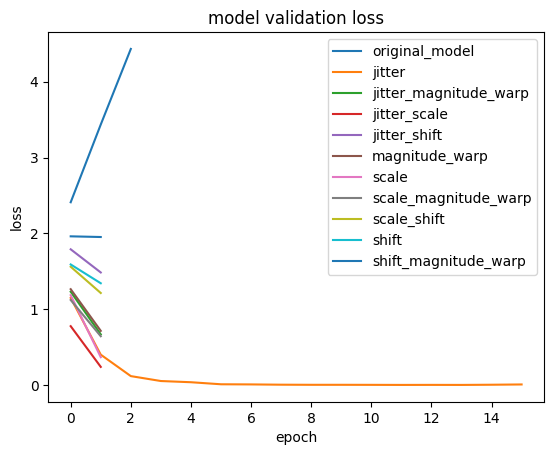

Evaluate model original_model
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
              precision    recall  f1-score   support

    Xin chào       0.49      0.94      0.64       299
         Tôi       1.00      1.00      1.00       300
         Tên       0.94      0.96      0.95       300
        Tiến       0.93      1.00      0.96       300
    Tạm biệt       0.00      0.00      0.00       301

    accuracy                           0.78      1500
   macro avg       0.67      0.78      0.71      1500
weighted avg       0.67      0.78      0.71      1500



/home/orange/miniconda3/envs/ASL_glove/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/orange/miniconda3/envs/ASL_glove/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/orange/miniconda3/envs/ASL_glove/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

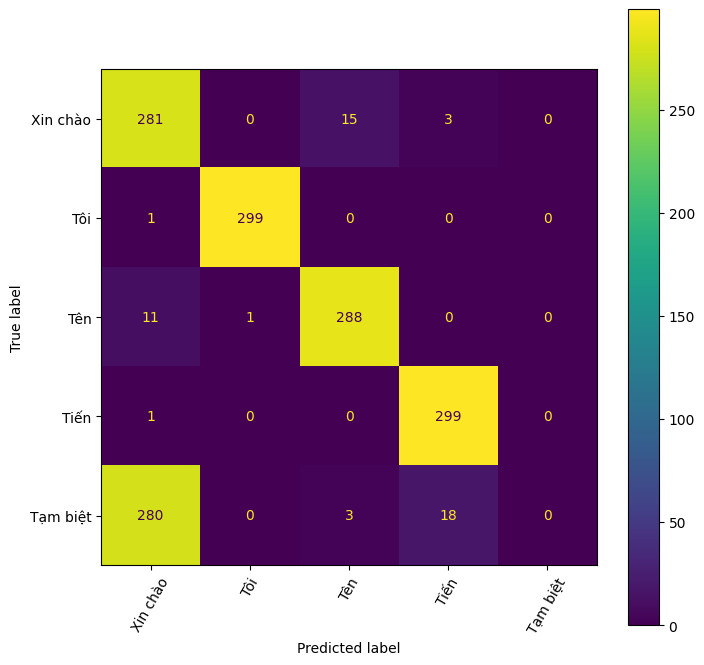

Evaluate model jitter
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
              precision    recall  f1-score   support

    Xin chào       0.97      1.00      0.98       299
         Tôi       1.00      1.00      1.00       300
         Tên       1.00      1.00      1.00       300
        Tiến       1.00      1.00      1.00       300
    Tạm biệt       1.00      0.97      0.98       301

    accuracy                           0.99      1500
   macro avg       0.99      0.99      0.99      1500
weighted avg       0.99      0.99      0.99      1500



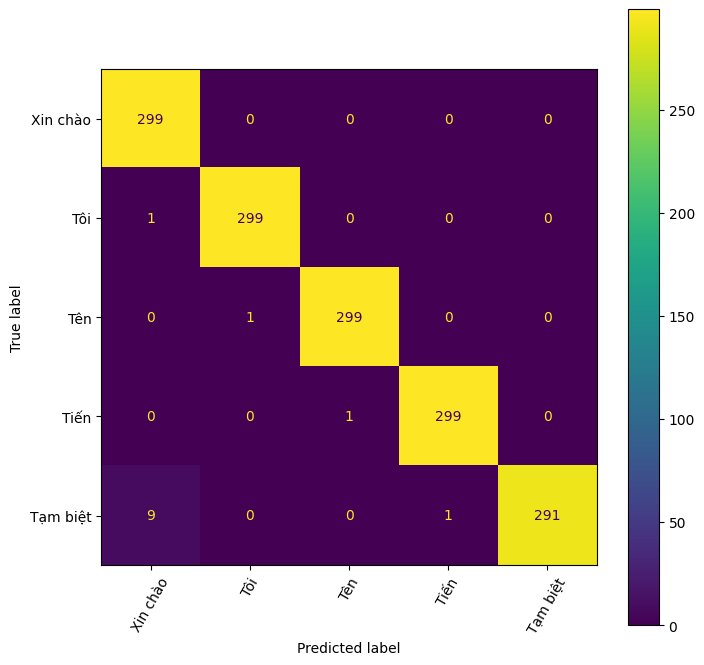

Evaluate model jitter_magnitude_warp
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
              precision    recall  f1-score   support

    Xin chào       0.96      0.92      0.94       299
         Tôi       1.00      1.00      1.00       300
         Tên       0.91      0.99      0.95       300
        Tiến       1.00      1.00      1.00       300
    Tạm biệt       0.99      0.94      0.96       301

    accuracy                           0.97      1500
   macro avg       0.97      0.97      0.97      1500
weighted avg       0.97      0.97      0.97      1500



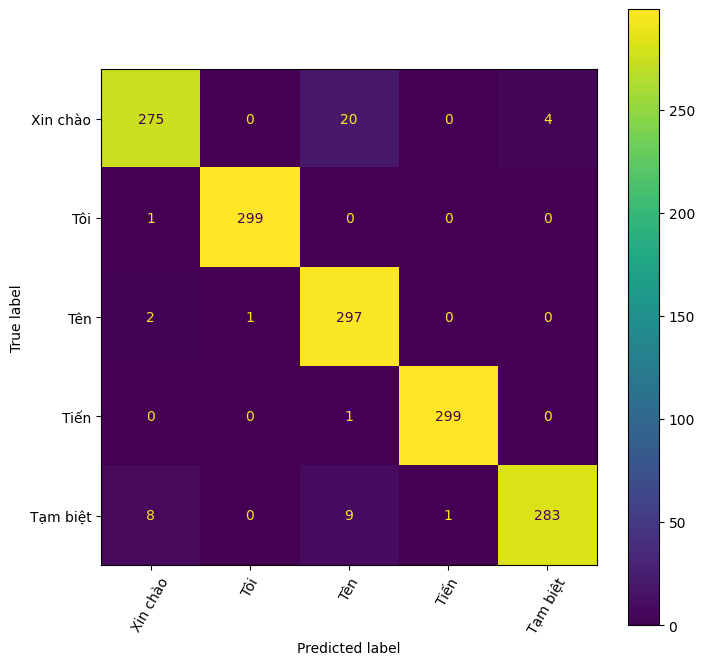

Evaluate model jitter_scale
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
              precision    recall  f1-score   support

    Xin chào       0.95      0.89      0.92       299
         Tôi       1.00      1.00      1.00       300
         Tên       0.97      0.97      0.97       300
        Tiến       0.99      1.00      0.99       300
    Tạm biệt       0.92      0.97      0.95       301

    accuracy                           0.96      1500
   macro avg       0.96      0.96      0.96      1500
weighted avg       0.96      0.96      0.96      1500



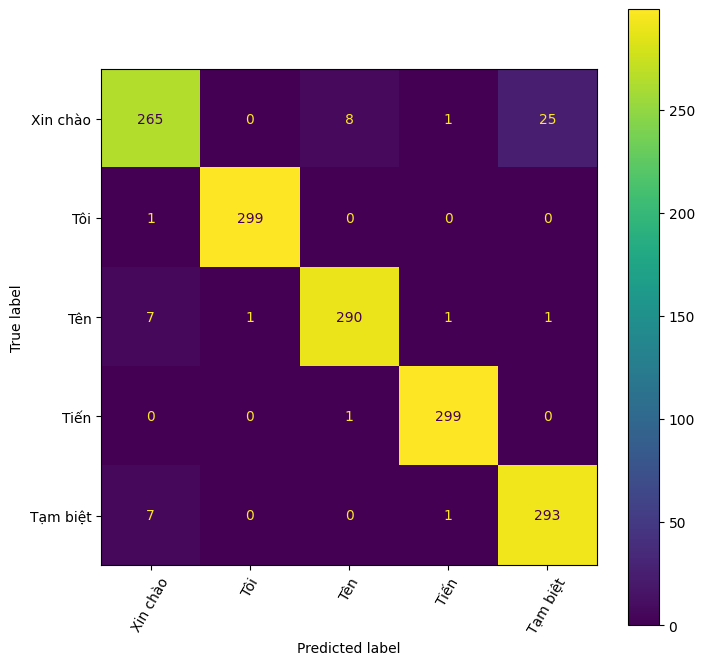

Evaluate model jitter_shift
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
              precision    recall  f1-score   support

    Xin chào       0.87      0.97      0.92       299
         Tôi       0.99      1.00      1.00       300
         Tên       0.98      0.87      0.92       300
        Tiến       1.00      0.99      0.99       300
    Tạm biệt       0.97      0.95      0.96       301

    accuracy                           0.96      1500
   macro avg       0.96      0.96      0.96      1500
weighted avg       0.96      0.96      0.96      1500



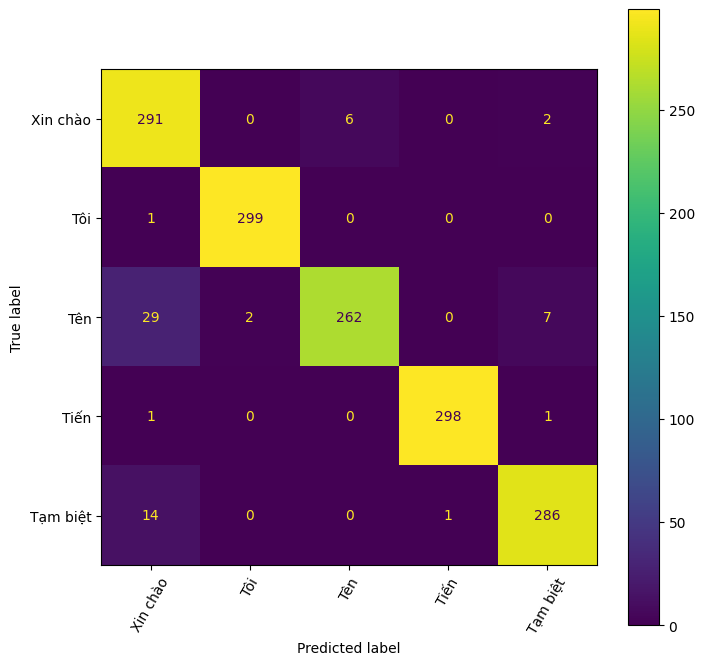

Evaluate model magnitude_warp
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
              precision    recall  f1-score   support

    Xin chào       0.89      0.96      0.92       299
         Tôi       0.98      1.00      0.99       300
         Tên       0.97      0.94      0.96       300
        Tiến       0.98      1.00      0.99       300
    Tạm biệt       0.98      0.90      0.94       301

    accuracy                           0.96      1500
   macro avg       0.96      0.96      0.96      1500
weighted avg       0.96      0.96      0.96      1500



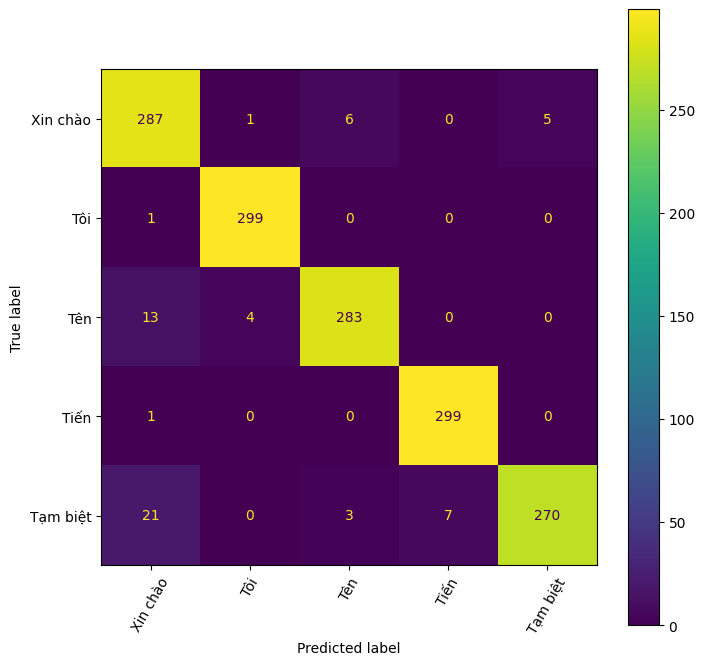

Evaluate model scale
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
              precision    recall  f1-score   support

    Xin chào       0.96      0.90      0.93       299
         Tôi       1.00      1.00      1.00       300
         Tên       0.89      0.99      0.94       300
        Tiến       0.99      1.00      1.00       300
    Tạm biệt       0.96      0.91      0.94       301

    accuracy                           0.96      1500
   macro avg       0.96      0.96      0.96      1500
weighted avg       0.96      0.96      0.96      1500



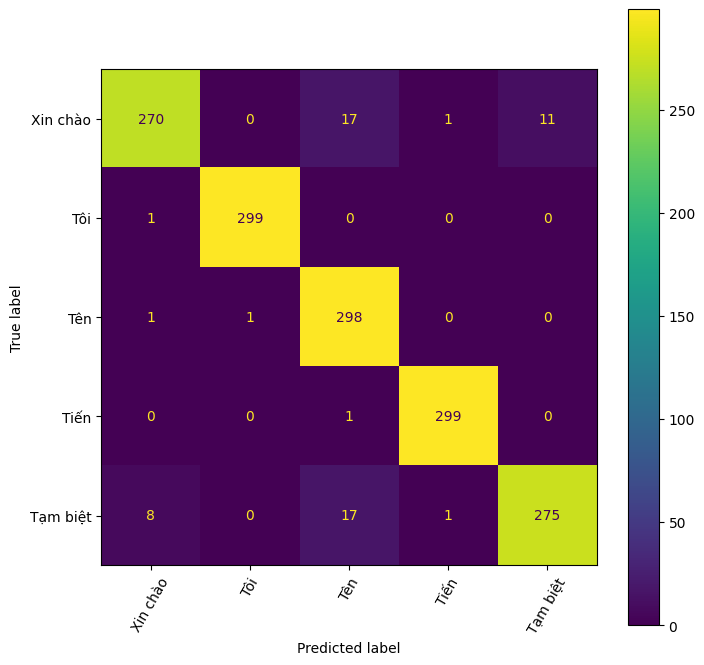

Evaluate model scale_magnitude_warp
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
              precision    recall  f1-score   support

    Xin chào       0.97      0.86      0.91       299
         Tôi       0.99      1.00      1.00       300
         Tên       0.89      0.99      0.94       300
        Tiến       0.98      1.00      0.99       300
    Tạm biệt       0.98      0.96      0.97       301

    accuracy                           0.96      1500
   macro avg       0.96      0.96      0.96      1500
weighted avg       0.96      0.96      0.96      1500



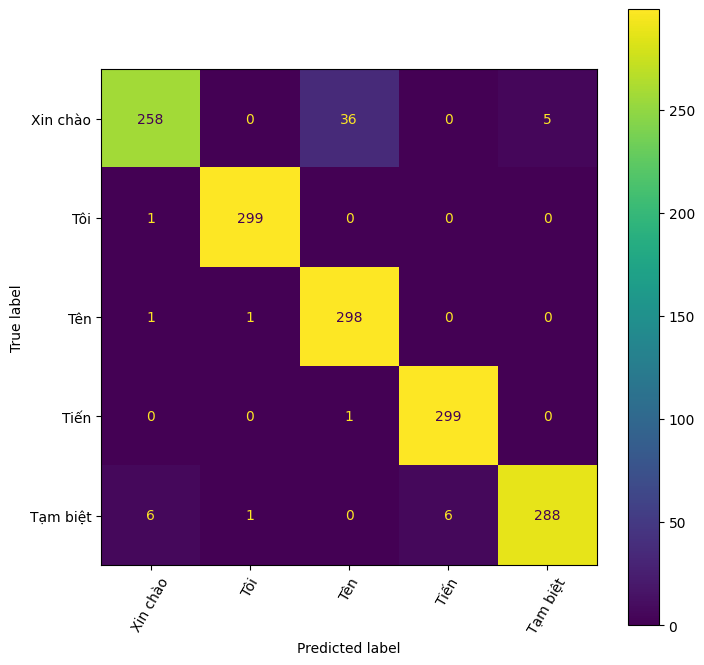

Evaluate model scale_shift
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
              precision    recall  f1-score   support

    Xin chào       0.94      0.94      0.94       299
         Tôi       1.00      1.00      1.00       300
         Tên       0.96      0.98      0.97       300
        Tiến       0.98      1.00      0.99       300
    Tạm biệt       0.98      0.95      0.97       301

    accuracy                           0.97      1500
   macro avg       0.97      0.97      0.97      1500
weighted avg       0.97      0.97      0.97      1500



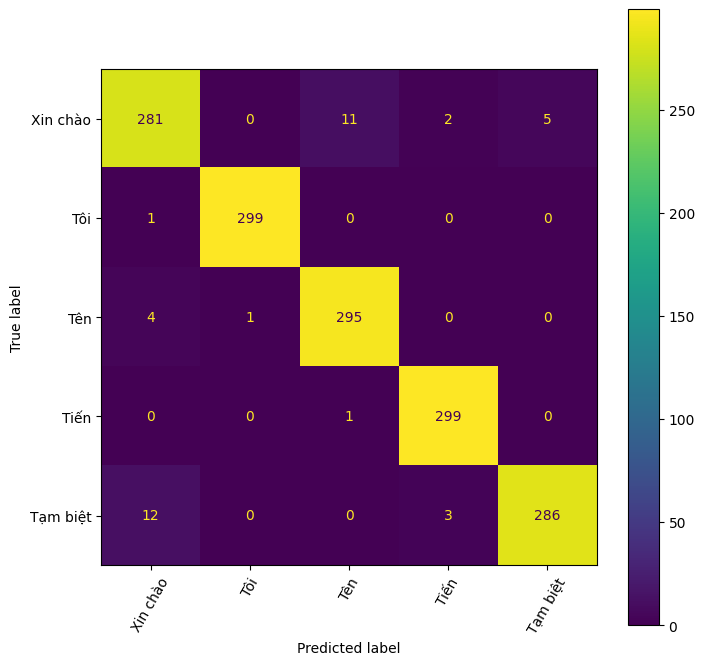

Evaluate model shift
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
              precision    recall  f1-score   support

    Xin chào       0.98      1.00      0.99       299
         Tôi       1.00      1.00      1.00       300
         Tên       0.99      0.98      0.99       300
        Tiến       1.00      1.00      1.00       300
    Tạm biệt       1.00      0.99      1.00       301

    accuracy                           0.99      1500
   macro avg       0.99      0.99      0.99      1500
weighted avg       0.99      0.99      0.99      1500



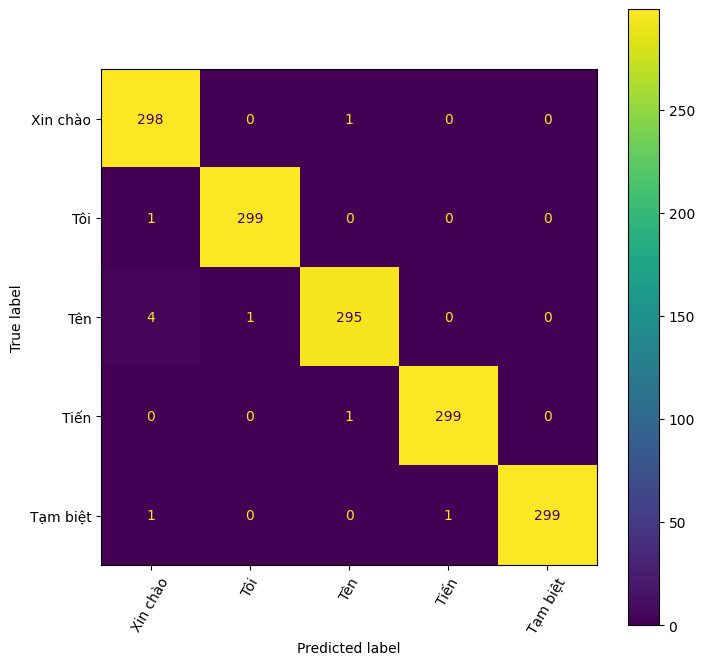

Evaluate model shift_magnitude_warp
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
              precision    recall  f1-score   support

    Xin chào       0.94      0.92      0.93       299
         Tôi       1.00      1.00      1.00       300
         Tên       0.94      0.96      0.95       300
        Tiến       0.99      1.00      1.00       300
    Tạm biệt       0.97      0.97      0.97       301

    accuracy                           0.97      1500
   macro avg       0.97      0.97      0.97      1500
weighted avg       0.97      0.97      0.97      1500



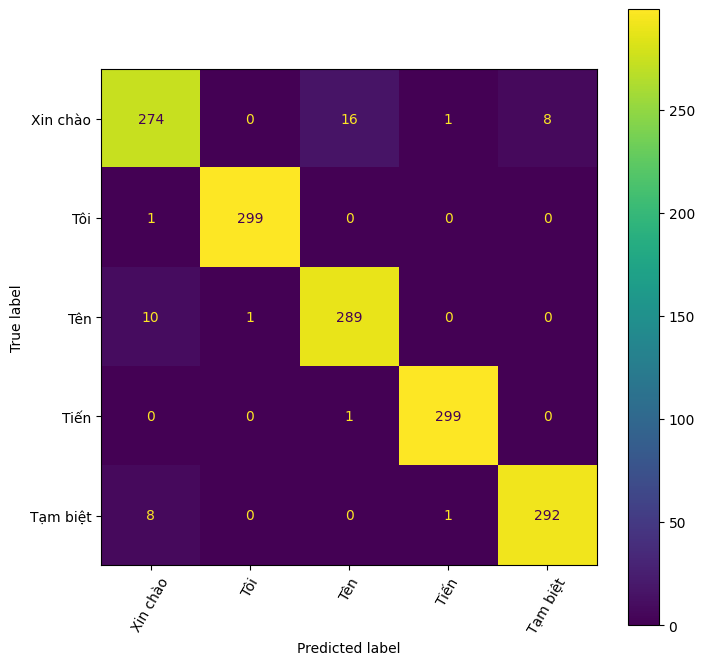

Evaluate model all_data_model
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
              precision    recall  f1-score   support

    Xin chào       0.99      1.00      0.99       299
         Tôi       1.00      1.00      1.00       300
         Tên       1.00      1.00      1.00       300
        Tiến       1.00      1.00      1.00       300
    Tạm biệt       1.00      0.99      0.99       301

    accuracy                           0.99      1500
   macro avg       0.99      0.99      0.99      1500
weighted avg       0.99      0.99      0.99      1500



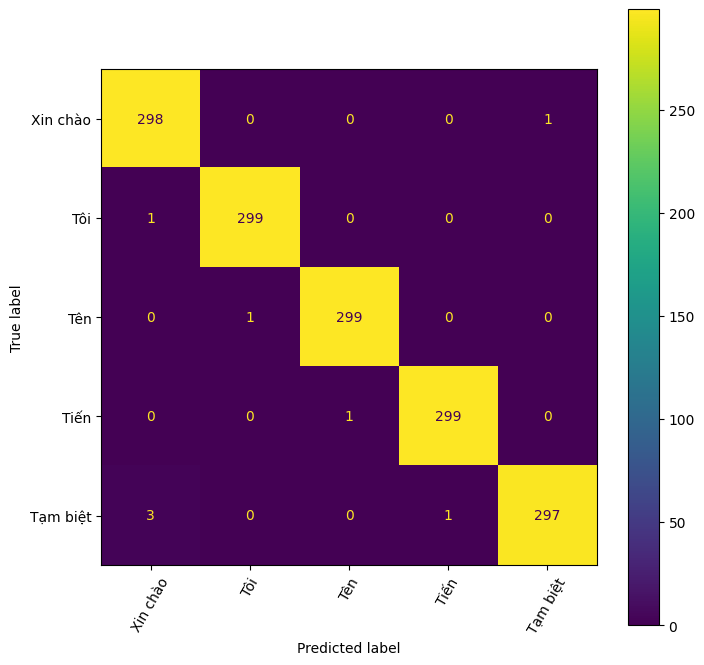

In [4]:
def main():
    trainX, trainy, testX, testy = readdata(trainx_file, trainy_file, testx_file, testy_file)
    class_names = readConfig()
    timesteps, n_features, num_classes = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)
    
    data_augmentation, techniques = read_enlarged_data()
    models = []
    history = []
    
    scaler = StandardScaler()

    original_model = create_model(timesteps, n_features, num_classes)
    original_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    history.append(original_model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, validation_split = 0.2, verbose=verbose, callbacks=[early_stopping]))
    models.append(original_model)


    for data, technique in zip(data_augmentation, techniques):
        train_x = np.vstack([trainX, data])
        train_y = np.vstack([trainy, trainy])
        # train_x = scaler.fit_transform(train_x.reshape(-1, train_x.shape[-1])).reshape(train_x.shape)
        model = create_model(timesteps, n_features, num_classes, name=technique)
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        history.append(model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, validation_split = 0.2, verbose=verbose, callbacks=[early_stopping]))
        models.append(model)
    

    all_data = np.vstack(data_augmentation)
    all_data = np.vstack([trainX, all_data])
    all_y = np.concatenate([trainy] * (len(data_augmentation) + 1), axis=0)

    all_data_model = create_model(timesteps, n_features, num_classes, name="all_data_model")
    all_data_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    all_data_model.fit(all_data, all_y, epochs=epochs, batch_size=batch_size, validation_split = 0.2, verbose=verbose, callbacks=[early_stopping])

    models.append(all_data_model)

    plot_val_loss(models, history)
    
    for model in models:
        model.save(f"./old_model_weights/{model.name}.h5")
        # testX = scaler.fit_transform(testX.reshape(-1, testX.shape[-1])).reshape(testX.shape)
        evaluate_model(model, testX, testy, class_names)


if __name__ == "__main__":
    main()
